In [1]:
# Settion 1: Setting Up the testing pipeline

In [2]:
def save_to_csv(df, file_name):
    df.to_csv(file_name, index=False)


def read_csv(file_name):
    return pd.read_csv(file_name)

In [3]:
# Analysis of `Generate_PCSP.py` indicates that generating a PCSP file necessitates the following parameters:

date = '2021-02-21'
ply1_name = 'Novak Djokovic'
ply2_name = 'Daniil Medvedev'
ply1_hand = 'RH'
ply2_hand = 'RH'





In [4]:
# The `Betting_Simulation.py` script indicates 
# Prediction by MDP, should have columns ['date', 'P1Name', 'P2Name', 'P1WinProb', 'P2WinProb']
# pred_mdp = pd.read_csv('MDP_pred.csv')
# Additionally, the betting script depends on CSV files in the betting folder, 
# which follow a different naming convention compared to 'tennisabstract-v2-combined.csv'.
# For example:
# 'tennisabstract-v2-combined.csv' lists the name as 'Florian Mayer',
# whereas in the betting folder, it is listed as 'Mayer F.'.


In [5]:
# Here is the result upon running the Betting_Simulation.py

# 579it [00:04, 132.60it/s]
# Profits: 534, total input:26400, total win: 88, num of bet: 264
# Bank Roll: 10534

In [6]:
# To validate our model's efficacy and to create PCSP files for varied matches, we need a 'helper.csv'. 
# This auxiliary file should contain columns: ['player_name', 'Converted Name', 'WRank', 'hand'].
# 'WRank' will be instrumental for refining our model.
# Match data is sourced from 'tennisabstract-v2-combined.csv' which includes player hand preference, 
# while 'WRank' can be derived from CSV files within the betting folder.




In [7]:
# Run these commands in a Jupyter notebook cell to install the packages
!pip install pandas
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install natsort


In [8]:
import pandas as pd
from fuzzywuzzy import process
from natsort import natsorted
import os
from natsort import natsorted
import warnings
from dateutil.relativedelta import relativedelta
from tqdm import tqdm as tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import re
import csv
import numpy as np
import math
from sklearn.metrics import brier_score_loss, log_loss
import glob

import warnings
# Suppress warnings from openpyxl about unknown extensions.
# These warnings are raised when openpyxl encounters file elements that are not
# directly related to the data, such as some types of formatting, macros, or proprietary
# extensions. Since these do not affect the data extraction process, and our focus is on
# reading the data correctly, we can safely ignore these warnings.
# However, if you encounter issues with the data, consider reviewing these warnings
# to ensure they are not related to the problem.
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

In [9]:
# obtain shot-by-shot data
file = 'tennisabstract-v2-combined.csv'
data = pd.read_csv(file, names=['ply1_name', 'ply2_name', 'ply1_hand', 'ply2_hand', 'ply1_points',
                                'ply2_points', 'ply1_games', 'ply2_games', 'ply1_sets', 'ply2_sets', 'date',
                                'tournament_name', 'shot_type', 'from_which_court', 'shot', 'direction',
                                'to_which_court', 'depth', 'touched_net', 'hit_at_depth', 'approach_shot',
                                'shot_outcome', 'fault_type', 'prev_shot_type', 'prev_shot_from_which_court',
                                'prev_shot', 'prev_shot_direction', 'prev_shot_to_which_court', 'prev_shot_depth',
                                'prev_shot_touched_net', 'prev_shot_hit_at_depth', 'prev_shot_approach_shot',
                                'prev_shot_outcome', 'prev_shot_fault_type', 'prev_prev_shot_type',
                                'prev_prev_shot_from_which_court', 'prev_prev_shot', 'prev_prev_shot_direction',
                                'prev_prev_shot_to_which_court', 'prev_prev_shot_depth',
                                'prev_prev_shot_touched_net', 'prev_prev_shot_hit_at_depth',
                                'prev_prev_shot_approach_shot', 'prev_prev_shot_outcome',
                                'prev_prev_shot_fault_type', 'url', 'description'])

In [10]:
# Extract unique player names from both 'ply1_name' and 'ply2_name' columns
unique_players = pd.concat(
    [data['ply1_name'], data['ply2_name']]).drop_duplicates().reset_index(drop=True)

In [11]:
# Transform player name format in 'tennisabstract-v2-combined.csv' to align with the format used in 'betting.xlsx'.

def convert_name(source_name):
    parts = source_name.split()
    if len(parts) < 2:
        return source_name
    first_name_initial = parts[0][0]
    last_name = parts[-1]
    target_name = f"{last_name} {first_name_initial}."
    return target_name

In [12]:
# # List all Excel files in the betting directory and its subdirectories
# betting_dir = './betting'
# excel_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(betting_dir) for f in filenames if f.endswith('.xlsx')]

# # Sort the files naturally by their filename (which is expected to represent years)
# sorted_excel_files = natsorted(excel_files)

# # Initialize an empty DataFrame to hold all the concatenated data
# combined_df = pd.DataFrame()

# # Read each file and concatenate it to the combined_df DataFrame
# for file in sorted_excel_files:
#     df = pd.read_excel(file)
#     # Assuming that 'Winner' and 'WRank' columns are present in all files
#     combined_df = pd.concat([combined_df, df[['Winner', 'WRank']]], ignore_index=True)

# # Remove duplicates, keeping the last occurrence (which is from the latest file due to sorting)
# combined_df = combined_df.drop_duplicates(subset='Winner', keep='last')

In [13]:
# Read the Excel files just once
women_df = pd.read_excel('.\\betting\\women\\2017.xlsx')
men_df = pd.read_excel('.\\betting\\men\\2017.xlsx')

# Concatenate the two dataframes for easier searching
combined_df = pd.concat([women_df, men_df], ignore_index=True)

In [14]:
# Update the dataframe to include the rank info

def update_rank(source_name, combined_df, current_index, total_players):
    target_name = convert_name(source_name)

    # Use fuzzy matching to find the closest match to the target name in the Winner column
    best_match, score = process.extractOne(target_name, combined_df['Winner'].unique())

    # If a good match is found (e.g., score > 85), get the WRank
    if score > 85:
        rank = combined_df[combined_df['Winner'] == best_match]['WRank'].values[0]
        print(f"[{current_index + 1}/{total_players}] Found match for {source_name}. Rank: {rank}. Remaining: {total_players - current_index - 1}")
        return target_name, rank
    else:
        print(f"[{current_index + 1}/{total_players}] No match for {source_name}. Remaining: {total_players - current_index - 1}")
        return target_name, None

In [15]:
# Convert the Series to a DataFrame
unique_players_df = unique_players.to_frame(name='player_name')

# Create new columns for Converted Name and WRank in the DataFrame
unique_players_df['Converted Name'] = ''
unique_players_df['WRank'] = ''

# Total number of players
total_players = len(unique_players_df)

# Update each player name in the DataFrame
for index, row in unique_players_df.iterrows():
    player = row['player_name']
    converted_name, rank = update_rank(player, combined_df, index, total_players)
    unique_players_df.at[index, 'Converted Name'] = converted_name
    if rank is not None:
        unique_players_df.at[index, 'WRank'] = rank

# Save the updated data to a different file
unique_players_df.to_csv('helper.csv', index=False)

[1/1073] Found match for Robin Soderling. Rank: 18.0. Remaining: 1072
[2/1073] Found match for Michael Berrer. Rank: 79.0. Remaining: 1071
[3/1073] Found match for Florian Mayer. Rank: 51.0. Remaining: 1070
[4/1073] Found match for Radek Stepanek. Rank: 107.0. Remaining: 1069
[5/1073] Found match for Roger Federer. Rank: 17.0. Remaining: 1068
[6/1073] Found match for Nikolay Davydenko. Rank: 48.0. Remaining: 1067
[7/1073] Found match for Marion Bartoli. Rank: 79.0. Remaining: 1066
[8/1073] Found match for Dinara Safina. Rank: 244.0. Remaining: 1065
[9/1073] Found match for Alicia Molik. Rank: 3.0. Remaining: 1064
[10/1073] Found match for Sara Errani. Rank: 53.0. Remaining: 1063
[11/1073] Found match for Kim Clijsters. Rank: 76.0. Remaining: 1062
[12/1073] Found match for Victoria Azarenka. Rank: nan. Remaining: 1061
[13/1073] Found match for Klara Koukalova. Rank: 76.0. Remaining: 1060
[14/1073] Found match for Jarmila Gajdosova. Rank: 10.0. Remaining: 1059
[15/1073] Found match for G

[121/1073] Found match for Lourdes Dominguez Lino. Rank: 62.0. Remaining: 952
[122/1073] Found match for Andrea Hlavackova. Rank: 378.0. Remaining: 951
[123/1073] Found match for Jerzy Janowicz. Rank: 267.0. Remaining: 950
[124/1073] Found match for Sam Querrey. Rank: 32.0. Remaining: 949
[125/1073] Found match for Lucie Safarova. Rank: 62.0. Remaining: 948
[126/1073] Found match for Benjamin Mitchell. Rank: 162.0. Remaining: 947
[127/1073] Found match for Roberto Bautista Agut. Rank: 14.0. Remaining: 946
[128/1073] Found match for Tsvetana Pironkova. Rank: 63.0. Remaining: 945
[129/1073] Found match for Ashleigh Barty. Rank: 271.0. Remaining: 944
[130/1073] Found match for Timea Babos. Rank: 33.0. Remaining: 943
[131/1073] Found match for Marinko Matosevic. Rank: 40.0. Remaining: 942
[132/1073] Found match for Kirsten Flipkens. Rank: 73.0. Remaining: 941
[133/1073] Found match for Monica Niculescu. Rank: 38.0. Remaining: 940
[134/1073] Found match for Shuai Peng. Rank: 83.0. Remaining

[242/1073] Found match for Pablo Carreno Busta. Rank: 30.0. Remaining: 831
[243/1073] Found match for Adrian Mannarino. Rank: 65.0. Remaining: 830
[244/1073] Found match for Thiemo De Bakker. Rank: 15.0. Remaining: 829
[245/1073] Found match for Dusan Lajovic. Rank: 94.0. Remaining: 828
[246/1073] Found match for Kristyna Pliskova. Rank: 6.0. Remaining: 827
[247/1073] Found match for Mohamed Safwat. Rank: 282.0. Remaining: 826
[248/1073] Found match for Eduardo Russi. Rank: 14.0. Remaining: 825
[249/1073] Found match for Vania King. Rank: 77.0. Remaining: 824
[250/1073] Found match for Paolo Lorenzi. Rank: 41.0. Remaining: 823
[251/1073] Found match for Mauricio Echazu. Rank: 79.0. Remaining: 822
[252/1073] Found match for Filip Krajinovic. Rank: 77.0. Remaining: 821
[253/1073] Found match for Santiago Giraldo. Rank: 97.0. Remaining: 820
[254/1073] Found match for Maria Teresa Torro Flor. Rank: 79.0. Remaining: 819
[255/1073] Found match for Mathias Bourgue. Rank: 79.0. Remaining: 818


[361/1073] Found match for Norbert Gombos. Rank: 128.0. Remaining: 712
[362/1073] Found match for Borna Coric. Rank: 61.0. Remaining: 711
[363/1073] Found match for Yuichi Sugita. Rank: 91.0. Remaining: 710
[364/1073] Found match for Go Soeda. Rank: 310.0. Remaining: 709
[365/1073] Found match for Lucas Pouille. Rank: 15.0. Remaining: 708
[366/1073] Found match for Radu Albot. Rank: 92.0. Remaining: 707
[367/1073] Found match for Tereza Smitkova. Rank: 826.0. Remaining: 706
[368/1073] Found match for Vitalia Diatchenko. Rank: 77.0. Remaining: 705
[369/1073] Found match for Luksika Kumkhum. Rank: 155.0. Remaining: 704
[370/1073] Found match for Marsel Ilhan. Rank: 287.0. Remaining: 703
[371/1073] Found match for Alex Kuznetsov. Rank: 48.0. Remaining: 702
[372/1073] Found match for Jason Kubler. Rank: 170.0. Remaining: 701
[373/1073] Found match for Guido Pella. Rank: 166.0. Remaining: 700
[374/1073] Found match for Julia Glushko. Rank: 340.0. Remaining: 699
[375/1073] Found match for Da

[481/1073] Found match for Nao Hibino. Rank: 106.0. Remaining: 592
[482/1073] Found match for Risa Ozaki. Rank: 100.0. Remaining: 591
[483/1073] Found match for Aslan Karatsev. Rank: 27.0. Remaining: 590
[484/1073] Found match for Misa Eguchi. Rank: 79.0. Remaining: 589
[485/1073] Found match for Jose Pereira. Rank: 340.0. Remaining: 588
[486/1073] Found match for Yaraslau Shyla. Rank: 58.0. Remaining: 587
[487/1073] Found match for Guido Andreozzi. Rank: 142.0. Remaining: 586
[488/1073] Found match for Nicolas Kicker. Rank: 116.0. Remaining: 585
[489/1073] Found match for Amra Sadikovic. Rank: 271.0. Remaining: 584
[490/1073] Found match for Facundo Arguello. Rank: 143.0. Remaining: 583
[491/1073] Found match for Marcelo Arevalo. Rank: 79.0. Remaining: 582
[492/1073] Found match for Orlando Luz. Rank: 193.0. Remaining: 581
[493/1073] Found match for Darian King. Rank: 140.0. Remaining: 580
[494/1073] Found match for Christian Lindell. Rank: 12.0. Remaining: 579
[495/1073] Found match 

[599/1073] Found match for Alexey Vatutin. Rank: 27.0. Remaining: 474
[600/1073] Found match for Andrew Whittington. Rank: 194.0. Remaining: 473
[601/1073] Found match for Yannik Reuter. Rank: 34.0. Remaining: 472
[602/1073] Found match for Antonia Lottner. Rank: 174.0. Remaining: 471
[603/1073] Found match for Deniz Khazaniuk. Rank: 386.0. Remaining: 470
[604/1073] Found match for Gregoire Barrere. Rank: 200.0. Remaining: 469
[605/1073] Found match for Reilly Opelka. Rank: 180.0. Remaining: 468
[606/1073] Found match for Casper Ruud. Rank: 208.0. Remaining: 467
[607/1073] Found match for Mikael Torpegaard. Rank: 40.0. Remaining: 466
[608/1073] Found match for Vaclav Safranek. Rank: 77.0. Remaining: 465
[609/1073] Found match for Jasmine Paolini. Rank: 340.0. Remaining: 464
[610/1073] Found match for Cindy Burger. Rank: 171.0. Remaining: 463
[611/1073] Found match for Varvara Flink. Rank: 89.0. Remaining: 462
[612/1073] Found match for Valeriya Strakhova. Rank: 77.0. Remaining: 461
[61

[726/1073] Found match for Corentin Moutet. Rank: 38.0. Remaining: 347
[727/1073] Found match for Attila Balazs. Rank: 174.0. Remaining: 346
[728/1073] Found match for Viktor Galovic. Rank: 77.0. Remaining: 345
[729/1073] Found match for Mirza Basic. Rank: 209.0. Remaining: 344
[730/1073] Found match for Jaqueline Cristian. Rank: 341.0. Remaining: 343
[731/1073] Found match for Ashley Kratzer. Rank: 27.0. Remaining: 342
[732/1073] Found match for Danielle Lao. Rank: 26.0. Remaining: 341
[733/1073] Found match for Claire Liu. Rank: 19.0. Remaining: 340
[734/1073] Found match for Sebastian Ofner. Rank: 216.0. Remaining: 339
[735/1073] Found match for Mihaela Buzarnescu. Rank: 105.0. Remaining: 338
[736/1073] Found match for Anna Bondar. Rank: 27.0. Remaining: 337
[737/1073] Found match for Yannick Maden. Rank: 186.0. Remaining: 336
[738/1073] Found match for Arantxa Rus. Rank: 207.0. Remaining: 335
[739/1073] Found match for Priscilla Hon. Rank: 308.0. Remaining: 334
[740/1073] Found mat

[845/1073] Found match for Diane Parry. Rank: 26.0. Remaining: 228
[846/1073] Found match for Cem Ilkel. Rank: 19.0. Remaining: 227
[847/1073] Found match for Kevin Krawietz. Rank: 76.0. Remaining: 226
[848/1073] Found match for Danilo Petrovic. Rank: 96.0. Remaining: 225
[849/1073] Found match for Daniel Altmaier. Rank: 252.0. Remaining: 224
[850/1073] Found match for Emma Navarro. Rank: 12.0. Remaining: 223
[851/1073] Found match for Daria Snigur. Rank: 244.0. Remaining: 222
[852/1073] Found match for Corentin Denolly. Rank: 12.0. Remaining: 221
[853/1073] Found match for Gijs Brouwer. Rank: 200.0. Remaining: 220
[854/1073] Found match for Holger Rune. Rank: 71.0. Remaining: 219
[855/1073] Found match for Ivan Gakhov. Rank: 92.0. Remaining: 218
[856/1073] Found match for Simona Waltert. Rank: 83.0. Remaining: 217
[857/1073] Found match for Enzo Couacaud. Rank: 347.0. Remaining: 216
[858/1073] Found match for Sandro Ehrat. Rank: 9.0. Remaining: 215
[859/1073] Found match for Kamilla R

[962/1073] Found match for Yana Morderger. Rank: 295.0. Remaining: 111
[963/1073] Found match for Tess Sugnaux. Rank: 826.0. Remaining: 110
[964/1073] Found match for Lucia Bronzetti. Rank: 61.0. Remaining: 109
[965/1073] Found match for Federica Di Sarra. Rank: 168.0. Remaining: 108
[966/1073] No match for Weronika Falkowska. Remaining: 107
[967/1073] Found match for Ben Shelton. Rank: 158.0. Remaining: 106
[968/1073] Found match for Tim Van Rijthoven. Rank: 33.0. Remaining: 105
[969/1073] Found match for Emina Bektas. Rank: 192.0. Remaining: 104
[970/1073] Found match for Seone Mendez. Rank: 9.0. Remaining: 103
[971/1073] No match for Olivia Gadecki. Remaining: 102
[972/1073] Found match for Yuriko Miyazaki. Rank: 64.0. Remaining: 101
[973/1073] Found match for Robin Montgomery. Rank: 18.0. Remaining: 100
[974/1073] Found match for Kristina Dmitruk. Rank: 76.0. Remaining: 99
[975/1073] Found match for Franco Agamenone. Rank: 143.0. Remaining: 98
[976/1073] Found match for Arianne Har

In [16]:
# Add player hand to helper.csv

def merge_hand_to_player_name(data, player_name_file):
    # Read the updated_player_name.csv
    updated_player_name = pd.read_csv(player_name_file)

    # Merge ply1_hand based on player_name
    merged1 = pd.merge(updated_player_name, data[['ply1_name', 'ply1_hand']].drop_duplicates(),
                       left_on='player_name', right_on='ply1_name', how='left')

    # Merge ply2_hand based on player_name
    merged2 = pd.merge(merged1, data[['ply2_name', 'ply2_hand']].drop_duplicates(),
                       left_on='player_name', right_on='ply2_name', how='left')

    # Combine the hand columns
    merged2['hand'] = merged2['ply1_hand'].combine_first(merged2['ply2_hand'])

    # Drop unnecessary columns
    merged2.drop(columns=['ply1_name', 'ply1_hand',
                 'ply2_name', 'ply2_hand'], inplace=True)

    return merged2

player_name_file = "helper.csv"
unique_players_df = merge_hand_to_player_name(data, player_name_file)
save_to_csv(unique_players_df, player_name_file)

In [17]:
#     Modifies the generate_pcsp function to output the PCSP file into either an 'updated' 
#     or 'original' subfolder within the 'pcsp' directory. This modification aids in the 
#     comparison and validation of the efficiency of an improved model against the baseline model. 
#     By organizing the outputs into separate subfolders, users can easily manage and analyze 
#     the results from different versions of the model.

def generate_pcsp(params, date, ply1_name, ply2_name, hand1, hand2, sub_directory="base"):
    VAR = 'var.txt'
    HAND = '%s_%s.txt' % (hand1, hand2)

  # Try to convert the date to the desired format
    try:
        date_obj = datetime.strptime(date, '%d/%m/%Y')
    except ValueError:
        try:
            date_obj = datetime.strptime(date, '%Y-%m-%d')
        except ValueError:
            # As a last resort, use dateutil.parser.parse
            date_obj = parse(date)

    formatted_date = date_obj.strftime('%Y-%m-%d')

    # Ensure the sub_directory is either "original" or "updated"
    if sub_directory not in ["base", "rank"]:
        raise ValueError(
            "sub_directory must be either 'base', 'rank'")

    # Create the 'pcsp' directory if it doesn't exist
    if not os.path.exists('pcsp'):
        os.makedirs('pcsp')

    # Create the specified sub_directory inside 'pcsp' if it doesn't exist
    if not os.path.exists(f'pcsp/{sub_directory}'):
        os.makedirs(f'pcsp/{sub_directory}')

    # Modify the file_name to include the sub-directory and the specified sub_directory
    file_name = f'pcsp/{sub_directory}/'
    file_name += '%s_%s_' % (hand1, hand2)
    file_name += '%s_%s_%s.pcsp' % (formatted_date,
                                    ply1_name.replace(' ', '-'), ply2_name.replace(' ', '-'))

    # write to file
    lines = []
    with open(VAR) as f:
        lines_1 = f.readlines()
    lines_2 = []
    for i, p in enumerate(params):
        lines_2.append('#define p%d %d;\n' % (i, p))
    with open(HAND) as f:
        lines_3 = f.readlines()
    lines = lines_1 + lines_2 + lines_3
    with open(file_name, 'w') as f:
        for line in lines:
            f.write(line)

In [18]:
# The baseline model's `get_params` method is implemented in its original form without modifications.

def get_params(df, hand):
    # Serve
    De_Serve = df.query('shot_type==1 and from_which_court==1')
    De_Serve_2nd = df.query('shot_type==2 and from_which_court==1')
    Ad_Serve = df.query('shot_type==1 and from_which_court==3')
    Ad_Serve_2nd = df.query('shot_type==2 and from_which_court==3')
    # Return
    De_ForeHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==1 and shot<=20')
    Ad_ForeHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==3 and shot<=20')
    De_BackHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==1 and shot<=40 and shot>20')
    Ad_BackHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==3 and shot<=40 and shot>20')
    # Stroke
    De_Stroke = df.query('shot_type==4 and from_which_court==1')
    Mid_Stroke = df.query('shot_type==4 and from_which_court==2')
    Ad_Stroke = df.query('shot_type==4 and from_which_court==3')

    results = []
    # Serve
    for Serve in [De_Serve, De_Serve_2nd, Ad_Serve, Ad_Serve_2nd]:
        ServeT = Serve.query('direction==6')
        ServeB = Serve.query('direction==5')
        ServeW = Serve.query('direction==4')
        serve_in = [len(x.query('shot_outcome==7'))
                    for x in [ServeT, ServeB, ServeW]]
        serve_win = [len(Serve.query('shot_outcome in [1, 5, 6]'))]
        serve_err = [len(Serve.query('shot_outcome in [2, 3, 4]'))]
        results.append(serve_in + serve_win + serve_err)

    # Return
    if hand == 'RH':  # RH
        directions = [[[[1], [1]], [[1], [3]], [[1], [2]]],                    # FH_[CC, DL, DM]
                      [[[2, 3], [3]], [[3], [1]], [[2], [1]], [
                          [2, 3], [2]]],  # FH_[IO, II, CC, DM]
                      [[[2], [3]], [[1], [3]], [[1, 2], [1]], [
                          [1, 2], [2]]],  # BH_[CC, II, IO, DM]
                      [[[3], [3]], [[3], [1]], [[3], [2]]]]                    # BH_[CC, DL, DM]
    else:  # LH
        directions = [[[[1, 2], [1]], [[1], [3]], [[2], [3]], [[1, 2], [2]]],  # FH_[IO, II, CC, DM]
                      # FH_[CC, DL, DM]
                      [[[3], [3]], [[3], [1]], [[3], [2]]],
                      # BH_[CC, DL, DM]
                      [[[1], [1]], [[1], [3]], [[1], [2]]],
                      [[[2], [1]], [[3], [1]], [[2, 3], [3]], [[2, 3], [2]]]]  # BH_[CC, II, IO, DM]
    for i, Return in enumerate([De_ForeHandR, Ad_ForeHandR, De_BackHandR, Ad_BackHandR]):
        shots = [Return.query(
            'from_which_court in @dir[0] and to_which_court in @dir[1]') for dir in directions[i]]
        return_in = [len(x.query('shot_outcome==7')) for x in shots]
        return_win = [len(Return.query('shot_outcome in [1, 5, 6]'))]
        return_err = [len(Return.query('shot_outcome in [2, 3, 4]'))]
        results.append(return_in + return_win + return_err)

    # Rally
    if hand == 'RH':  # RH
        directions = [[[1, 3, 2], [3, 1, 2]],  # de - FHCC, FHDL, FHDM, BHII, BHIO, BHDM
                      # mid - FHIO, FHCC, FHDM, BHIO, BHCC, BHDM
                      [[3, 1, 2], [1, 3, 2]],
                      [[3, 1, 2], [3, 1, 2]]]  # ad - FHIO, FHII, FHDM, BHCC, BHDL, BHDM

    else:  # LH
        directions = [[[1, 3, 2], [1, 3, 2]],  # de - FHIO, FHII, FHDM, BHCC, BHDL, BHDM
                      # mid - FHIO, FHCC, FHDM, BHIO, BHCC, BHDM
                      [[1, 3, 2], [3, 1, 2]],
                      [[3, 1, 2], [1, 3, 2]]]  # ad - FHCC, FHDL, FHDM, BHII, BHIO, BHDM
    for i, Stroke in enumerate([De_Stroke, Mid_Stroke, Ad_Stroke]):
        FH_Stroke = Stroke.query('shot<=20')
        BH_Stroke = Stroke.query('shot<=40 and shot>20')
        FH_shots = [FH_Stroke.query('to_which_court==@to_dir')
                    for to_dir in directions[i][0]]
        BH_shots = [BH_Stroke.query('to_which_court==@to_dir')
                    for to_dir in directions[i][1]]
        shots = FH_shots + BH_shots
        FH_stroke_in = [len(x.query('shot_outcome==7')) for x in FH_shots]
        BH_stroke_in = [len(x.query('shot_outcome==7')) for x in BH_shots]
        stroke_win = [len(Stroke.query('shot_outcome in [1, 5, 6]'))]
        stroke_err = [len(Stroke.query('shot_outcome in [2, 3, 4]'))]
        results.append(FH_stroke_in + BH_stroke_in + stroke_win + stroke_err)

    return results


In [19]:
# In the baseline model's `generate_transition_probs` method, we edited it such that
# the PCSP file generation is skipped if either player has zero matches, 
# as this is considered insufficient data to carry out predictions.


def generate_transition_probs_base(data, date, ply1_name, ply2_name, ply1_hand, ply2_hand):
    prev_date = (pd.to_datetime(date) -
                 relativedelta(years=2)).strftime('%Y-%m-%d')

    data_ply1 = data.query(
        'date>=@prev_date and date<@date and ply1_name==@ply1_name and ply2_name==@ply2_name')
    data_ply2 = data.query(
        'date>=@prev_date and date<@date and ply1_name==@ply2_name and ply2_name==@ply1_name')

    # number of matches played
    num_ply1_prev_n = len(data_ply1.date.unique())
    num_ply2_prev_n = len(data_ply2.date.unique())

    ply1_params = get_params(data_ply1, ply1_hand)
    ply2_params = get_params(data_ply2, ply2_hand)

    # sample
    params = sum(ply1_params, []) + sum(ply2_params, [])

    print('# P1 matches:', num_ply1_prev_n)
    print('# P2 matches:', num_ply2_prev_n)
    
    # If either player has 0 matches, skip generating the pcsp file
    if num_ply1_prev_n == 0 or num_ply2_prev_n == 0:
        print('Skipping PCSP generation due to insufficient match data.')
        return
    generate_pcsp(params, date, ply1_name, ply2_name, ply1_hand, ply2_hand)


In [20]:
import pandas as pd

file_path = 'MDP_pred.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Convert the 'date' column to datetime, assuming it's in 'YYYY-MM-DD' format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

# Check if any dates were successfully parsed
if df['date'].isna().all():
    print("All dates were unparsable. Check the date format in your CSV file.")
else:
    # The format is already 'YYYY-MM-DD', so no need to reformat, but you can if you want to ensure consistency
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')

    # Save the updated DataFrame back to the same CSV file, overwriting it
    df.to_csv(file_path, index=False)
    print("Updated Data:")
    print(df.head())


Updated Data:
         date           P1Name               P2Name  P1WinProb  P2WinProb  \
0  2018-01-06     Nick Kyrgios      Grigor Dimitrov     0.6473     0.3527   
1  2018-01-02      Borna Coric  Pablo Carreno Busta     0.5472     0.4528   
2  2018-01-06     Gael Monfils        Andrey Rublev     0.5587     0.4412   
3  2018-01-09      Robin Haase          Casper Ruud     0.5998     0.4002   
4  2018-01-10  Karen Khachanov         Pablo Cuevas     0.3717     0.6283   

  P1Hand P2Hand  
0     RH     RH  
1     RH     RH  
2     RH     RH  
3     RH     RH  
4     RH     RH  


In [21]:
# For batch generation of PCSP files from 'MDP_pred.csv', 
# it's necessary to include 'P1Hand' and 'P2Hand' columns.


def merge_hand_for_players(mdp_df, player_name_df):
    # Merge hand information for P1Name
    merged1 = pd.merge(mdp_df, player_name_df[['player_name', 'hand']],
                       left_on='P1Name', right_on='player_name', how='left')
    merged1.rename(columns={'hand': 'P1Hand'}, inplace=True)
    merged1.drop(columns=['player_name'], inplace=True)

    # Merge hand information for P2Name
    merged2 = pd.merge(merged1, player_name_df[['player_name', 'hand']],
                       left_on='P2Name', right_on='player_name', how='left')
    merged2.rename(columns={'hand': 'P2Hand'}, inplace=True)
    merged2.drop(columns=['player_name'], inplace=True)

    return merged2


mdp_pred_file = "MDP_pred.csv"
player_name_file = "helper.csv"

player_name_df = read_csv(player_name_file)
mdp_df = read_csv(mdp_pred_file)

updated_mdp_df = merge_hand_for_players(mdp_df, player_name_df)
save_to_csv(updated_mdp_df, mdp_pred_file)

In [22]:
# Now we produce the pcsp model base on the base line model 
mdp_pred_file = "MDP_pred.csv"
mdp_df = read_csv(mdp_pred_file)


for index, row in mdp_df.iterrows():
    date = row['date']
    ply1_name = row['P1Name']
    ply2_name = row['P2Name']
    # Assuming ply1_hand and ply2_hand are available in the MDP_pred.csv
    ply1_hand = row['P1Hand']
    ply2_hand = row['P2Hand']

    generate_transition_probs_base(data, date, ply1_name,
                              ply2_name, ply1_hand, ply2_hand)


# P1 matches: 1
# P2 matches: 1
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient m

# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 2
# P2 matches: 2
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 1
# P2 matches: 1
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 1
# P2 matches: 1
# P1 matches: 3
# P2 matches: 3
# P1 matches: 1
# P2 matches: 1
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skippin

# P1 matches: 3
# P2 matches: 3
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 4
# P2 matches: 4
# P1 matches: 5
# P2 matches: 5
# P1 matches: 2
# P2 matches: 2
# P1 matches: 1
# P2 matches: 1
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skippin

# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 1
# P2 matches: 1
# P1 matches: 1
# P2 matches: 1
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 1
# P2 matches: 1
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 

# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 1
# P2 matches: 1
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient match data.
# P1 matches: 0
# P2 matches: 0
Skipping PCSP generation due to insufficient m

In [23]:
# Next we run the pcsp folder and generate our own baseline model testing MDP_pred.csv file we name it original.csv

def extract_probabilities(output_text):
    match = re.search(r'Probability \[(.*?), (.*?)\]', output_text)
    if match:
        probabilities = [float(match.group(1)), float(match.group(2))]
        return probabilities
    else:
        return None


def extract_info_from_filename(filename):
    # Extract date, P1Name, and P2Name from the filename
    match = re.search(r'RH_RH_(\d{4}-\d{2}-\d{2})_(.*?)_(.*?).pcsp', filename)
    if match:
        date, P1Name, P2Name = match.groups()

        # Replace hyphens with spaces in player names
        P1Name = P1Name.replace('-', ' ')
        P2Name = P2Name.replace('-', ' ')

        return date, P1Name, P2Name
    else:
        return None, None, None


def execute_and_read_output(pcsp_folder, filename):
    current_directory = os.getcwd()
    pcsp_file_path = os.path.join(
        pcsp_folder, filename)
    result_file_path = os.path.join(current_directory, 'result.txt')

    command = 'C:\\Program Files (x86)\\Process Analysis Toolkit\\Process Analysis Toolkit 3.5.1\\PAT3.Console.exe'
    args = ['-pcsp', pcsp_file_path, result_file_path]

    try:
        subprocess.run([command] + args, check=True)
        with open(result_file_path, 'r') as file:
            output = file.read()
            probabilities = extract_probabilities(output)
            if probabilities:
                return probabilities
            else:
                print(f"Probability values not found for file {filename}.")
                return 0.5, 0.5
    except Exception as e:
        print(f"An error occurred for file {filename}: {e}")
        return None, None



def process_pcsp_files(output_filename, pcsp_subfolder):
    pcsp_folder = os.path.join(os.getcwd(), pcsp_subfolder)
    output_data = []

    for filename in os.listdir(pcsp_folder):
        print(filename)
        if filename.endswith('.pcsp'):
            date, P1Name, P2Name = extract_info_from_filename(filename)
            if date and P1Name and P2Name:
                P1WinProbRange = execute_and_read_output(pcsp_folder, filename)
                if P1WinProbRange:
                    # Calculate the average win probability for P1
                    P1WinProbAvg = sum(P1WinProbRange) / 2
                    output_data.append(
                        [date, P1Name, P2Name, P1WinProbAvg, 1 - P1WinProbAvg])

    # Save the extracted data into a CSV file
    with open(output_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['date', 'P1Name', 'P2Name', 'P1WinProb', 'P2WinProb'])
        writer.writerows(output_data)


In [24]:
    output_csv_filename = 'base.csv'
    pcsp_relative_subfolder = 'pcsp/base'
    process_pcsp_files(output_csv_filename, pcsp_relative_subfolder)

LH_RH_2018-01-11_Angelique-Kerber_Dominika-Cibulkova.pcsp
LH_RH_2018-06-10_Rafael-Nadal_Dominic-Thiem.pcsp
LH_RH_2018-09-05_Rafael-Nadal_Dominic-Thiem.pcsp
RH_LH_2018-01-25_Simona-Halep_Angelique-Kerber.pcsp
RH_LH_2018-06-06_Simona-Halep_Angelique-Kerber.pcsp
RH_LH_2018-08-08_Elina-Svitolina_Mihaela-Buzarnescu.pcsp
RH_LH_2018-09-01_Juan-Martin-Del-Potro_Fernando-Verdasco.pcsp
RH_RH_2018-01-02_Karolina-Pliskova_Jelena-Ostapenko.pcsp
RH_RH_2018-01-04_Elina-Svitolina_Johanna-Konta.pcsp
RH_RH_2018-01-04_Katerina-Siniakova_Karolina-Pliskova.pcsp
RH_RH_2018-01-05_Elina-Svitolina_Karolina-Pliskova.pcsp
RH_RH_2018-01-06_Nick-Kyrgios_Grigor-Dimitrov.pcsp
RH_RH_2018-01-06_Simona-Halep_Katerina-Siniakova.pcsp
RH_RH_2018-01-08_Lesia-Tsurenko_Timea-Babos.pcsp
RH_RH_2018-01-09_Agnieszka-Radwanska_Johanna-Konta.pcsp
RH_RH_2018-01-10_Aryna-Sabalenka_Shuai-Zhang.pcsp
RH_RH_2018-01-15_Kiki-Bertens_Catherine-Cartan-Bellis.pcsp
RH_RH_2018-01-16_Agnieszka-Radwanska_Karolina-Pliskova.pcsp
RH_RH_2018-01-21_G

RH_RH_2018-09-24_Aryna-Sabalenka_Carla-Suarez-Navarro.pcsp
RH_RH_2018-09-24_Ashleigh-Barty_Johanna-Konta.pcsp
RH_RH_2018-09-28_Aryna-Sabalenka_Ashleigh-Barty.pcsp
RH_RH_2018-10-01_Julia-Goerges_Lesia-Tsurenko.pcsp
RH_RH_2018-10-03_Anastasija-Sevastova_Donna-Vekic.pcsp
RH_RH_2018-10-03_Dominika-Cibulkova_Sloane-Stephens.pcsp
RH_RH_2018-10-03_Juan-Martin-Del-Potro_Karen-Khachanov.pcsp
RH_RH_2018-10-04_Aryna-Sabalenka_Caroline-Garcia.pcsp
RH_RH_2018-10-04_Caroline-Wozniacki_Anett-Kontaveit.pcsp
RH_RH_2018-10-04_Fabio-Fognini_Andrey-Rublev.pcsp
RH_RH_2018-10-04_Naomi-Osaka_Julia-Goerges.pcsp
RH_RH_2018-10-05_Caroline-Wozniacki_Katerina-Siniakova.pcsp
RH_RH_2018-10-06_Caroline-Wozniacki_Qiang-Wang.pcsp
RH_RH_2018-10-06_Juan-Martin-Del-Potro_Fabio-Fognini.pcsp
RH_RH_2018-10-07_Caroline-Wozniacki_Anastasija-Sevastova.pcsp
RH_RH_2018-10-09_Benoit-Paire_Pablo-Carreno-Busta.pcsp
RH_RH_2018-10-11_Alexander-Zverev_Alex-De-Minaur.pcsp
RH_RH_2018-10-11_Borna-Coric_Juan-Martin-Del-Potro.pcsp
RH_RH_20

In [25]:
# Encapsulate the betting script into a function for reuse in future process.
def run_betting_strategy(Delta, target_year, initial_bankroll, predictions_csv):
    bankroll = initial_bankroll
    profit = 0
    total_input = 0
    num_of_win = 0
    num_of_bet = 0

    # Prediction by MDP, should have columns ['date', 'P1Name', 'P2Name', 'P1WinProb', 'P2WinProb']
    pred_mdp = pd.read_csv(predictions_csv)

    # Betting data
    betting_men = pd.read_excel(f'./betting/men/{target_year}.xlsx', engine='openpyxl')
    betting_women = pd.read_excel(f'./betting/women/{target_year}.xlsx', engine='openpyxl')
    betting = pd.concat([betting_men, betting_women], ignore_index=True)
    # Filter out wrong records
    betting = betting.query('Comment=="Completed"')
    betting = betting.query('AvgW<2 or AvgL<2')
    betting = betting.query('AvgW<=MaxW and AvgL<=MaxL')

    for index, match in tqdm(pred_mdp.iterrows(), total=pred_mdp.shape[0]):
        betonP1 = False
        betonP2 = False
        betAmount = 100

        # find corresponding match in betting csv
        P1Name = match.P1Name.split(' ')[-1]
        P2Name = match.P2Name.split(' ')[-1]
        market = betting.query(
            'Date==@match.date and Winner.str.contains(@P1Name) and Loser.str.contains(@P2Name)')
        if len(market) != 1 or math.isnan(market.iloc[0].AvgW) or math.isnan(market.iloc[0].AvgL):
            continue
        market = market.iloc[0]

        # mdp prediction
        P1WinProb = match.P1WinProb
        P2WinProb = 1 - P1WinProb

        # bookmaker prediction
        marketP1WinProb = 1 / market.AvgW
        marketP2WinProb = 1 / market.AvgL
        # because marketP1WinProb + marketP2WinProb != 1
        o = (marketP1WinProb + marketP2WinProb - 1) / 2

        # Betting strategy
        if marketP1WinProb + o + Delta < P1WinProb:
            betonP1 = True
        elif marketP2WinProb + o + Delta < P2WinProb:
            betonP2 = True

        # Update bankroll and profits
        winnings = 0
        if betonP1:
            winnings += (market.AvgW - 1) * betAmount
            num_of_win += 1
        elif betonP2:
            winnings -= betAmount
        num_of_bet += 1
        total_input += betAmount
        bankroll += winnings
        profit += winnings

        # Run out of money
        if bankroll <= 10:
            print(f'Run out of money after {total_input/100} bets!')
            break

    print(f'Profits: {profit}, total input: {total_input}, total win: {num_of_win}, num of bet: {num_of_bet}')
    print(f'Bank Roll: {bankroll}')
    return profit, bankroll, num_of_win, num_of_bet

In [26]:
Delta = 0.08
target_year = 2018
initial_bankroll = 10000
predictions_csv = 'base.csv'  # This is the filename for the predictions CSV
profits, final_bankroll, wins, bets = run_betting_strategy(Delta, target_year, initial_bankroll, predictions_csv)

100%|███████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 133.19it/s]

Profits: -287.99999999999994, total input: 18600, total win: 32, num of bet: 186
Bank Roll: 9712.0


In [27]:
import csv
import os
from datetime import datetime

# Define the path to the CSV file and the directory containing the files
csv_path = 'MDP_pred.csv'
files_directory = './pcsp/base'

# Function to normalize date to a datetime object


def normalize_date(date_str):
    for fmt in ('%Y-%m-%d', '%m/%d/%Y'):
        try:
            return datetime.strptime(date_str, fmt).date()
        except ValueError:
            pass
    raise ValueError(f"Date format for '{date_str}' is not recognized.")

# Function to clean and standardize player names for comparison


def clean_name(name):
    return ' '.join(name.split('-')).lower().strip()


# Read the CSV file
with open(csv_path, newline='') as csvfile:
    csv_reader = csv.DictReader(csvfile)
    csv_data = list(csv_reader)

# Normalize all CSV date strings to datetime objects for comparison
for row in csv_data:
    row['date'] = normalize_date(row['date'])

# Initialize a list to hold the matched records and a list for unmatched filenames
matched_records = []
unmatched_files = []

# Get all files in the specified directory and attempt to find matches in the CSV data
for filename in os.listdir(files_directory):
    if filename.endswith('.pcsp'):
        # Correctly split the filename
        parts = filename.rsplit('.', 1)[0].split('_')
        file_date = normalize_date(parts[2])
        file_p1_name = clean_name(parts[3])
        file_p2_name = clean_name(parts[4])

        match_found = False

        # Filter the CSV records for a match
        for row in csv_data:
            csv_p1_name = clean_name(row['P1Name'])
            csv_p2_name = clean_name(row['P2Name'])
            if row['date'] == file_date and csv_p1_name == file_p1_name and csv_p2_name == file_p2_name:
                matched_records.append(row)
                match_found = True
                break

        if not match_found:
            unmatched_files.append(filename)

# Export the matched records to a CSV file
matched_csv_path = 'MatchedRecords.csv'
with open(matched_csv_path, 'w', newline='') as csvfile:
    fieldnames = csv_data[0].keys()
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerows(matched_records)

# Print out the number of matched records and unmatched files
print(f"Number of matched records: {len(matched_records)}")
print(f"Number of unmatched files: {len(unmatched_files)}")

# Print out the unmatched file names for diagnostic purposes
if unmatched_files:
    print("\nUnmatched files:")
    for file in unmatched_files:
        print(file)


Number of matched records: 203
Number of unmatched files: 0


In [28]:
# Now we will implement the World ranking enhancement

In [53]:
# First we define a function to get the player rank
def get_player_rank(player_name, rank_df):
    """
    Get the rank of a player from the rank DataFrame.
    """
    rank_entry = rank_df[rank_df['player_name'] == player_name]

    if not rank_entry.empty and not pd.isnull(rank_entry['WRank'].iloc[0]):
        return rank_entry['WRank'].iloc[0]
    else:
        return 1500

In [68]:
import math

def compute_adjusted_win_rate(player_rank, c=0.05, d=200, invert=False):
    """
    Compute the adjusted win rate based on the player's rank, 
    where a higher-ranked player (numerically lower rank) has a higher win rate by default.
    The win rate does not go below 1, with a less steep curve in the first 200 ranks to show differences in win rates.
    
    :param player_rank: The rank of the player.
    :param c: The steepness of the logistic curve, set to create a less steep curve in the first 200 ranks.
    :param d: The mid-point shift of the logistic curve, set to reflect the top ranks.
    :param invert: When True, lower numerical ranks have higher win rates; when False, higher numerical ranks have higher win rates.
    :return: Adjusted win rate value.
    """
    if player_rank < 0 or player_rank > 1500:
        return 1  # Ensuring the rank is within a reasonable range

    # Adjust the formula based on the invert parameter
    if invert:
        # Inverted logic: Lower numerical rank (better player) has higher win rate
        adjusted_win_rate = 1 + 1 / (1 + math.exp((c * (player_rank - d))))
    else:
        # Non-inverted logic: Higher numerical rank has higher win rate
        adjusted_win_rate = 1 / (1 + math.exp(-(c * (player_rank - d))))
    
    return adjusted_win_rate



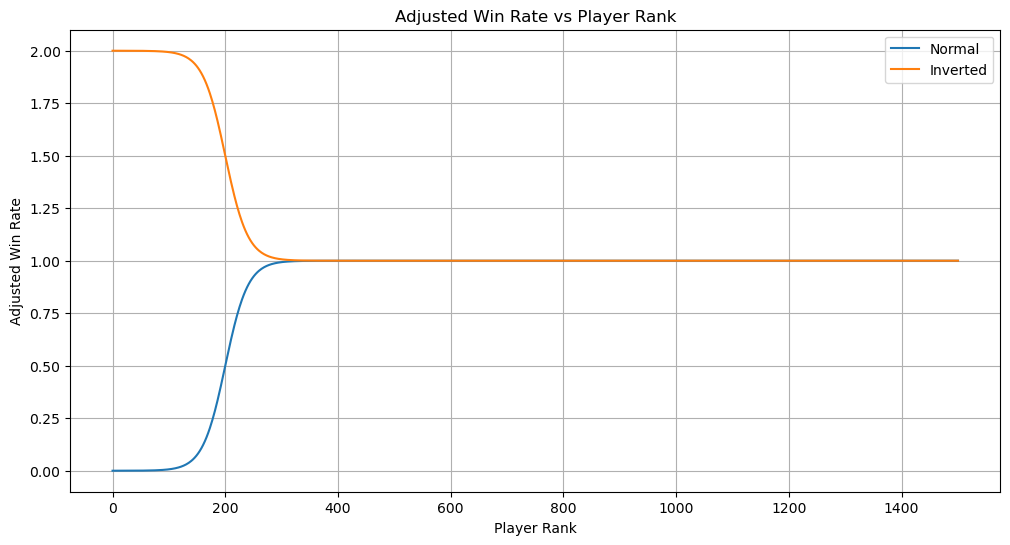

In [69]:
# This graph illustrates the 'compute_adjusted_win_rate' formula.
# The objective is for the world rank to influence the match outcome while remaining within a controllable range.

# Generate ranks and corresponding win rates
ranks = np.linspace(0, 1500, 1000)
win_rates_normal = [compute_adjusted_win_rate(rank, invert=False) for rank in ranks]
win_rates_inverted = [compute_adjusted_win_rate(rank, invert=True) for rank in ranks]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(ranks, win_rates_normal, label='Normal')
plt.plot(ranks, win_rates_inverted, label='Inverted')
plt.title('Adjusted Win Rate vs Player Rank')
plt.xlabel('Player Rank')
plt.ylabel('Adjusted Win Rate')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
# Adjust the outcomes based on the adjusted win rate

def adjust_outcomes_by_win_rate(outcomes, adjusted_win_rate):
    return [int(outcome * adjusted_win_rate) for outcome in outcomes]

In [71]:
# The get_params method has been updated to include adjusted_win_rate, which will influence the results of the actions.

def get_params_rank(df, hand, adjusted_win_rate):
    # Serve
    De_Serve = df.query('shot_type==1 and from_which_court==1')
    De_Serve_2nd = df.query('shot_type==2 and from_which_court==1')
    Ad_Serve = df.query('shot_type==1 and from_which_court==3')
    Ad_Serve_2nd = df.query('shot_type==2 and from_which_court==3')
    # Return
    De_ForeHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==1 and shot<=20')
    Ad_ForeHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==3 and shot<=20')
    De_BackHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==1 and shot<=40 and shot>20')
    Ad_BackHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==3 and shot<=40 and shot>20')
    # Stroke
    De_Stroke = df.query('shot_type==4 and from_which_court==1')
    Mid_Stroke = df.query('shot_type==4 and from_which_court==2')
    Ad_Stroke = df.query('shot_type==4 and from_which_court==3')

    results = []
    # Serve
    for Serve in [De_Serve, De_Serve_2nd, Ad_Serve, Ad_Serve_2nd]:
        ServeT = Serve.query('direction==6')
        ServeB = Serve.query('direction==5')
        ServeW = Serve.query('direction==4')
        serve_in = [len(x.query('shot_outcome==7'))
                    for x in [ServeT, ServeB, ServeW]]
        serve_win = [len(Serve.query('shot_outcome in [1, 5, 6]'))]
        serve_err = [len(Serve.query('shot_outcome in [2, 3, 4]'))]

        adjusted_serve_win = adjust_outcomes_by_win_rate(
            serve_win, adjusted_win_rate)

        results.append(serve_in +
                       adjusted_serve_win + serve_err)

    # Return
    if hand == 'RH':  # RH
        directions = [[[[1], [1]], [[1], [3]], [[1], [2]]],                    # FH_[CC, DL, DM]
                      [[[2, 3], [3]], [[3], [1]], [[2], [1]], [
                          [2, 3], [2]]],  # FH_[IO, II, CC, DM]
                      [[[2], [3]], [[1], [3]], [[1, 2], [1]], [
                          [1, 2], [2]]],  # BH_[CC, II, IO, DM]
                      [[[3], [3]], [[3], [1]], [[3], [2]]]]                    # BH_[CC, DL, DM]
    else:  # LH
        directions = [[[[1, 2], [1]], [[1], [3]], [[2], [3]], [[1, 2], [2]]],  # FH_[IO, II, CC, DM]
                      # FH_[CC, DL, DM]
                      [[[3], [3]], [[3], [1]], [[3], [2]]],
                      # BH_[CC, DL, DM]
                      [[[1], [1]], [[1], [3]], [[1], [2]]],
                      [[[2], [1]], [[3], [1]], [[2, 3], [3]], [[2, 3], [2]]]]  # BH_[CC, II, IO, DM]
    for i, Return in enumerate([De_ForeHandR, Ad_ForeHandR, De_BackHandR, Ad_BackHandR]):
        shots = [Return.query(
            'from_which_court in @dir[0] and to_which_court in @dir[1]') for dir in directions[i]]
        return_in = [len(x.query('shot_outcome==7')) for x in shots]
        return_win = [len(Return.query('shot_outcome in [1, 5, 6]'))]
        return_err = [len(Return.query('shot_outcome in [2, 3, 4]'))]

        adjusted_return_win = adjust_outcomes_by_win_rate(
            return_win, adjusted_win_rate)

        results.append(return_in +
                       adjusted_return_win + return_err)

    # Rally
    if hand == 'RH':  # RH
        directions = [[[1, 3, 2], [3, 1, 2]],  # de - FHCC, FHDL, FHDM, BHII, BHIO, BHDM
                      # mid - FHIO, FHCC, FHDM, BHIO, BHCC, BHDM
                      [[3, 1, 2], [1, 3, 2]],
                      [[3, 1, 2], [3, 1, 2]]]  # ad - FHIO, FHII, FHDM, BHCC, BHDL, BHDM

    else:  # LH
        directions = [[[1, 3, 2], [1, 3, 2]],  # de - FHIO, FHII, FHDM, BHCC, BHDL, BHDM
                      # mid - FHIO, FHCC, FHDM, BHIO, BHCC, BHDM
                      [[1, 3, 2], [3, 1, 2]],
                      [[3, 1, 2], [1, 3, 2]]]  # ad - FHCC, FHDL, FHDM, BHII, BHIO, BHDM
    for i, Stroke in enumerate([De_Stroke, Mid_Stroke, Ad_Stroke]):
        FH_Stroke = Stroke.query('shot<=20')
        BH_Stroke = Stroke.query('shot<=40 and shot>20')
        FH_shots = [FH_Stroke.query('to_which_court==@to_dir')
                    for to_dir in directions[i][0]]
        BH_shots = [BH_Stroke.query('to_which_court==@to_dir')
                    for to_dir in directions[i][1]]
        shots = FH_shots + BH_shots
        FH_stroke_in = [len(x.query('shot_outcome==7')) for x in FH_shots]
        BH_stroke_in = [len(x.query('shot_outcome==7')) for x in BH_shots]
        stroke_win = [len(Stroke.query('shot_outcome in [1, 5, 6]'))]
        stroke_err = [len(Stroke.query('shot_outcome in [2, 3, 4]'))]

        adjusted_stroke_win = adjust_outcomes_by_win_rate(
            stroke_win, adjusted_win_rate)

        results.append(FH_stroke_in + BH_stroke_in +
                       adjusted_stroke_win + stroke_err)


    return results

In [72]:
# The generate_transition_probs method has been updated to include rank info

def generate_transition_probs_rank(data, date, ply1_name, ply2_name, ply1_hand, ply2_hand):
    prev_date = (pd.to_datetime(date) -
                 relativedelta(years=2)).strftime('%Y-%m-%d')

    data_ply1 = data.query(
        'date>=@prev_date and date<@date and ply1_name==@ply1_name and ply2_name==@ply2_name')
    data_ply2 = data.query(
        'date>=@prev_date and date<@date and ply1_name==@ply2_name and ply2_name==@ply1_name')

    # number of matches played
    num_ply1_prev_n = len(data_ply1.date.unique())
    num_ply2_prev_n = len(data_ply2.date.unique())

    # Read the updated player rank CSV
    rank_df = pd.read_csv('helper.csv')

    # Get the ranks of the players
    ply1_rank = get_player_rank(ply1_name, rank_df)
    ply2_rank = get_player_rank(ply2_name, rank_df)

    # Print the ranks
    print(f"Rank of {ply1_name}: {ply1_rank}")
    print(f"Rank of {ply2_name}: {ply2_rank}")

    adjusted_win_rate_ply1 = compute_adjusted_win_rate(ply1_rank)
    adjusted_win_rate_ply2 = compute_adjusted_win_rate(ply2_rank)
    # Print the adjusted win rates
    print("Adjusted Win Rate for Player 1:", adjusted_win_rate_ply1)
    print("Adjusted Win Rate for Player 2:", adjusted_win_rate_ply2)
    # Adjust the parameters using the adjusted win rate
    ply1_params = get_params_rank(data_ply1, ply1_hand, adjusted_win_rate_ply1)
    ply2_params = get_params_rank(data_ply2, ply2_hand, adjusted_win_rate_ply2)

    # sample
    params = sum(ply1_params, []) + sum(ply2_params, [])

    print('# P1 matches:', num_ply1_prev_n)
    print('# P2 matches:', num_ply2_prev_n)
    # If either player has 0 matches, skip generating the pcsp file
    if num_ply1_prev_n == 0 or num_ply2_prev_n == 0:
        print('Skipping PCSP generation due to insufficient match data.')
        return
    generate_pcsp(params, date, ply1_name, ply2_name, ply1_hand, ply2_hand,"rank")


In [73]:
mdp_pred_file = "MatchedRecords.csv"
mdp_df = read_csv(mdp_pred_file)


for index, row in mdp_df.iterrows():
    date = row['date']
    ply1_name = row['P1Name']
    ply2_name = row['P2Name']
    ply1_hand = row['P1Hand']  
    ply2_hand = row['P2Hand']

    generate_transition_probs_rank(data, date, ply1_name, ply2_name, ply1_hand, ply2_hand)
    # Print progress
    print(f"Processed {index + 1} out of {len(mdp_df)} rows.")

Rank of Angelique Kerber: 1.0
Rank of Dominika Cibulkova: 5.0
Adjusted Win Rate for Player 1: 4.772535611847556e-05
Adjusted Win Rate for Player 2: 5.829126566113865e-05
# P1 matches: 1
# P2 matches: 1
Processed 1 out of 203 rows.
Rank of Rafael Nadal: 9.0
Rank of Dominic Thiem: 8.0
Adjusted Win Rate for Player 1: 7.119619380797805e-05
Adjusted Win Rate for Player 2: 6.772414961977011e-05
# P1 matches: 4
# P2 matches: 4
Processed 2 out of 203 rows.
Rank of Rafael Nadal: 9.0
Rank of Dominic Thiem: 8.0
Adjusted Win Rate for Player 1: 7.119619380797805e-05
Adjusted Win Rate for Player 2: 6.772414961977011e-05
# P1 matches: 5
# P2 matches: 5
Processed 3 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Angelique Kerber: 1.0
Adjusted Win Rate for Player 1: 5.5448524722794907e-05
Adjusted Win Rate for Player 2: 4.772535611847556e-05
# P1 matches: 5
# P2 matches: 5
Processed 4 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Angelique Kerber: 1.0
Adjusted Win Rate for Player 1: 5.544852472

# P1 matches: 3
# P2 matches: 3
Processed 36 out of 203 rows.
Rank of Juan Martin Del Potro: 42.0
Rank of Kevin Anderson: 79.0
Adjusted Win Rate for Player 1: 0.00037060614062639654
Adjusted Win Rate for Player 2: 0.0023523155709781456
# P1 matches: 1
# P2 matches: 1
Processed 37 out of 203 rows.
Rank of Sorana Cirstea: 78.0
Rank of Monica Niculescu: 38.0
Adjusted Win Rate for Player 1: 0.0022378485212763317
Adjusted Win Rate for Player 2: 0.00030344703002891917
# P1 matches: 1
# P2 matches: 1
Processed 38 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Karolina Pliskova: 6.0
Adjusted Win Rate for Player 1: 5.5448524722794907e-05
Adjusted Win Rate for Player 2: 6.127973961660237e-05
# P1 matches: 3
# P2 matches: 3
Processed 39 out of 203 rows.
Rank of Anastasija Sevastova: 33.0
Rank of Julia Goerges: 53.0
Adjusted Win Rate for Player 1: 0.0002363406483222142
Adjusted Win Rate for Player 2: 0.0006421797005859854
# P1 matches: 1
# P2 matches: 1
Processed 40 out of 203 rows.
Rank of Ju

# P1 matches: 3
# P2 matches: 3
Processed 72 out of 203 rows.
Rank of Karolina Pliskova: 6.0
Rank of Simona Halep: 4.0
Adjusted Win Rate for Player 1: 6.127973961660237e-05
Adjusted Win Rate for Player 2: 5.5448524722794907e-05
# P1 matches: 3
# P2 matches: 3
Processed 73 out of 203 rows.
Rank of Alexander Zverev: 24.0
Rank of Dominic Thiem: 8.0
Adjusted Win Rate for Player 1: 0.0001507103580597574
Adjusted Win Rate for Player 2: 6.772414961977011e-05
# P1 matches: 3
# P2 matches: 3
Processed 74 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Naomi Osaka: 48.0
Adjusted Win Rate for Player 1: 5.5448524722794907e-05
Adjusted Win Rate for Player 2: 0.0005002011070795639
# P1 matches: 4
# P2 matches: 4
Processed 75 out of 203 rows.
Rank of Caroline Wozniacki: 19.0
Rank of Anastasija Sevastova: 33.0
Adjusted Win Rate for Player 1: 0.0001173772578811046
Adjusted Win Rate for Player 2: 0.0002363406483222142
# P1 matches: 1
# P2 matches: 1
Processed 76 out of 203 rows.
Rank of Elina Svitoli

# P1 matches: 2
# P2 matches: 2
Processed 108 out of 203 rows.
Rank of Anastasija Sevastova: 33.0
Rank of Sorana Cirstea: 78.0
Adjusted Win Rate for Player 1: 0.0002363406483222142
Adjusted Win Rate for Player 2: 0.0022378485212763317
# P1 matches: 1
# P2 matches: 1
Processed 109 out of 203 rows.
Rank of John Isner: 19.0
Rank of Ryan Harrison: 89.0
Adjusted Win Rate for Player 1: 0.0001173772578811046
Adjusted Win Rate for Player 2: 0.0038724034406710283
# P1 matches: 1
# P2 matches: 1
Processed 110 out of 203 rows.
Rank of Alexander Zverev: 24.0
Rank of Kei Nishikori: 5.0
Adjusted Win Rate for Player 1: 0.0001507103580597574
Adjusted Win Rate for Player 2: 5.829126566113865e-05
# P1 matches: 2
# P2 matches: 2
Processed 111 out of 203 rows.
Rank of Juan Martin Del Potro: 42.0
Rank of Damir Dzumhur: 86.0
Adjusted Win Rate for Player 1: 0.00037060614062639654
Adjusted Win Rate for Player 2: 0.0033348073074133443
# P1 matches: 1
# P2 matches: 1
Processed 112 out of 203 rows.
Rank of Alex 

# P1 matches: 1
# P2 matches: 1
Processed 144 out of 203 rows.
Rank of Sloane Stephens: 934.0
Rank of Elise Mertens: 127.0
Adjusted Win Rate for Player 1: 0.9999999999999998
Adjusted Win Rate for Player 2: 0.02533270322687172
# P1 matches: 2
# P2 matches: 2
Processed 145 out of 203 rows.
Rank of Juan Martin Del Potro: 42.0
Rank of John Isner: 19.0
Adjusted Win Rate for Player 1: 0.00037060614062639654
Adjusted Win Rate for Player 2: 0.0001173772578811046
# P1 matches: 3
# P2 matches: 3
Processed 146 out of 203 rows.
Rank of Madison Keys: 9.0
Rank of Carla Suarez Navarro: 12.0
Adjusted Win Rate for Player 1: 7.119619380797805e-05
Adjusted Win Rate for Player 2: 8.271722285166639e-05
# P1 matches: 1
# P2 matches: 1
Processed 147 out of 203 rows.
Rank of Naomi Osaka: 48.0
Rank of Madison Keys: 9.0
Adjusted Win Rate for Player 1: 0.0005002011070795639
Adjusted Win Rate for Player 2: 7.119619380797805e-05
# P1 matches: 1
# P2 matches: 1
Processed 148 out of 203 rows.
Rank of Serena Williams

# P1 matches: 1
# P2 matches: 1
Processed 180 out of 203 rows.
Rank of Karolina Pliskova: 6.0
Rank of Caroline Wozniacki: 19.0
Adjusted Win Rate for Player 1: 6.127973961660237e-05
Adjusted Win Rate for Player 2: 0.0001173772578811046
# P1 matches: 3
# P2 matches: 3
Processed 181 out of 203 rows.
Rank of Elina Svitolina: 14.0
Rank of Karolina Pliskova: 6.0
Adjusted Win Rate for Player 1: 9.141587385216144e-05
Adjusted Win Rate for Player 2: 6.127973961660237e-05
# P1 matches: 2
# P2 matches: 2
Processed 182 out of 203 rows.
Rank of Elina Svitolina: 14.0
Rank of Caroline Wozniacki: 19.0
Adjusted Win Rate for Player 1: 9.141587385216144e-05
Adjusted Win Rate for Player 2: 0.0001173772578811046
# P1 matches: 2
# P2 matches: 2
Processed 183 out of 203 rows.
Rank of Elina Svitolina: 14.0
Rank of Kiki Bertens: 22.0
Adjusted Win Rate for Player 1: 9.141587385216144e-05
Adjusted Win Rate for Player 2: 0.00013637032707949703
# P1 matches: 1
# P2 matches: 1
Processed 184 out of 203 rows.
Rank of

In [74]:
output_csv_filename = 'rank.csv'
pcsp_relative_subfolder = 'pcsp/rank'
process_pcsp_files(output_csv_filename, pcsp_relative_subfolder)

LH_RH_2018-01-11_Angelique-Kerber_Dominika-Cibulkova.pcsp
LH_RH_2018-06-10_Rafael-Nadal_Dominic-Thiem.pcsp
LH_RH_2018-09-05_Rafael-Nadal_Dominic-Thiem.pcsp
RH_LH_2018-01-25_Simona-Halep_Angelique-Kerber.pcsp
RH_LH_2018-06-06_Simona-Halep_Angelique-Kerber.pcsp
RH_LH_2018-08-08_Elina-Svitolina_Mihaela-Buzarnescu.pcsp
RH_LH_2018-09-01_Juan-Martin-Del-Potro_Fernando-Verdasco.pcsp
RH_RH_2018-01-02_Karolina-Pliskova_Jelena-Ostapenko.pcsp
RH_RH_2018-01-04_Elina-Svitolina_Johanna-Konta.pcsp
RH_RH_2018-01-04_Katerina-Siniakova_Karolina-Pliskova.pcsp
RH_RH_2018-01-05_Elina-Svitolina_Karolina-Pliskova.pcsp
RH_RH_2018-01-06_Nick-Kyrgios_Grigor-Dimitrov.pcsp
RH_RH_2018-01-06_Simona-Halep_Katerina-Siniakova.pcsp
RH_RH_2018-01-08_Lesia-Tsurenko_Timea-Babos.pcsp
RH_RH_2018-01-09_Agnieszka-Radwanska_Johanna-Konta.pcsp
RH_RH_2018-01-10_Aryna-Sabalenka_Shuai-Zhang.pcsp
RH_RH_2018-01-15_Kiki-Bertens_Catherine-Cartan-Bellis.pcsp
RH_RH_2018-01-16_Agnieszka-Radwanska_Karolina-Pliskova.pcsp
RH_RH_2018-01-21_G

RH_RH_2018-09-24_Aryna-Sabalenka_Carla-Suarez-Navarro.pcsp
RH_RH_2018-09-24_Ashleigh-Barty_Johanna-Konta.pcsp
RH_RH_2018-09-28_Aryna-Sabalenka_Ashleigh-Barty.pcsp
RH_RH_2018-10-01_Julia-Goerges_Lesia-Tsurenko.pcsp
RH_RH_2018-10-03_Anastasija-Sevastova_Donna-Vekic.pcsp
RH_RH_2018-10-03_Dominika-Cibulkova_Sloane-Stephens.pcsp
RH_RH_2018-10-03_Juan-Martin-Del-Potro_Karen-Khachanov.pcsp
RH_RH_2018-10-04_Aryna-Sabalenka_Caroline-Garcia.pcsp
RH_RH_2018-10-04_Caroline-Wozniacki_Anett-Kontaveit.pcsp
RH_RH_2018-10-04_Fabio-Fognini_Andrey-Rublev.pcsp
RH_RH_2018-10-04_Naomi-Osaka_Julia-Goerges.pcsp
RH_RH_2018-10-05_Caroline-Wozniacki_Katerina-Siniakova.pcsp
RH_RH_2018-10-06_Caroline-Wozniacki_Qiang-Wang.pcsp
RH_RH_2018-10-06_Juan-Martin-Del-Potro_Fabio-Fognini.pcsp
RH_RH_2018-10-07_Caroline-Wozniacki_Anastasija-Sevastova.pcsp
RH_RH_2018-10-09_Benoit-Paire_Pablo-Carreno-Busta.pcsp
RH_RH_2018-10-11_Alexander-Zverev_Alex-De-Minaur.pcsp
RH_RH_2018-10-11_Borna-Coric_Juan-Martin-Del-Potro.pcsp
RH_RH_20

In [75]:
predictions_csv = 'rank.csv'  # This is the filename for the predictions CSV

Delta = 0.08
target_year = 2018
initial_bankroll = 10000

# The run_betting_strategy function would be called with the modified CSV file
profits, final_bankroll, wins, bets = run_betting_strategy(Delta, target_year, initial_bankroll, predictions_csv)


100%|███████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 132.56it/s]

Profits: 1399.0, total input: 18600, total win: 56, num of bet: 186
Bank Roll: 11399.0


In [63]:
# Compute the adjusted win rate based on the player's rank

def compute_adjusted_win_rate(player_rank, alpha=0.05):
    # Calculate the adjusted win rate
    adjusted_win_rate = 1 / (alpha * math.log(player_rank + 1, 10))

    # Print the adjusted win rate
    print(f"Adjusted Win Rate for Rank {player_rank}: {adjusted_win_rate}")

    return adjusted_win_rate

In [64]:
# The get_params method has been updated to include adjusted_win_rate, which will influence the results of the actions.

def get_params_rank(df, hand, adjusted_win_rate):
    # Serve
    De_Serve = df.query('shot_type==1 and from_which_court==1')
    De_Serve_2nd = df.query('shot_type==2 and from_which_court==1')
    Ad_Serve = df.query('shot_type==1 and from_which_court==3')
    Ad_Serve_2nd = df.query('shot_type==2 and from_which_court==3')
    # Return
    De_ForeHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==1 and shot<=20')
    Ad_ForeHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==3 and shot<=20')
    De_BackHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==1 and shot<=40 and shot>20')
    Ad_BackHandR = df.query(
        'shot_type==3 and prev_shot_from_which_court==3 and shot<=40 and shot>20')
    # Stroke
    De_Stroke = df.query('shot_type==4 and from_which_court==1')
    Mid_Stroke = df.query('shot_type==4 and from_which_court==2')
    Ad_Stroke = df.query('shot_type==4 and from_which_court==3')

    results = []
    # Serve
    for Serve in [De_Serve, De_Serve_2nd, Ad_Serve, Ad_Serve_2nd]:
        ServeT = Serve.query('direction==6')
        ServeB = Serve.query('direction==5')
        ServeW = Serve.query('direction==4')
        serve_in = [len(x.query('shot_outcome==7'))
                    for x in [ServeT, ServeB, ServeW]]
        serve_win = [len(Serve.query('shot_outcome in [1, 5, 6]'))]
        serve_err = [len(Serve.query('shot_outcome in [2, 3, 4]'))]

        adjusted_serve_win = adjust_outcomes_by_win_rate(
            serve_win, adjusted_win_rate)

        results.append(serve_in +
                       adjusted_serve_win + serve_err)

    # Return
    if hand == 'RH':  # RH
        directions = [[[[1], [1]], [[1], [3]], [[1], [2]]],                    # FH_[CC, DL, DM]
                      [[[2, 3], [3]], [[3], [1]], [[2], [1]], [
                          [2, 3], [2]]],  # FH_[IO, II, CC, DM]
                      [[[2], [3]], [[1], [3]], [[1, 2], [1]], [
                          [1, 2], [2]]],  # BH_[CC, II, IO, DM]
                      [[[3], [3]], [[3], [1]], [[3], [2]]]]                    # BH_[CC, DL, DM]
    else:  # LH
        directions = [[[[1, 2], [1]], [[1], [3]], [[2], [3]], [[1, 2], [2]]],  # FH_[IO, II, CC, DM]
                      # FH_[CC, DL, DM]
                      [[[3], [3]], [[3], [1]], [[3], [2]]],
                      # BH_[CC, DL, DM]
                      [[[1], [1]], [[1], [3]], [[1], [2]]],
                      [[[2], [1]], [[3], [1]], [[2, 3], [3]], [[2, 3], [2]]]]  # BH_[CC, II, IO, DM]
    for i, Return in enumerate([De_ForeHandR, Ad_ForeHandR, De_BackHandR, Ad_BackHandR]):
        shots = [Return.query(
            'from_which_court in @dir[0] and to_which_court in @dir[1]') for dir in directions[i]]
        return_in = [len(x.query('shot_outcome==7')) for x in shots]
        return_win = [len(Return.query('shot_outcome in [1, 5, 6]'))]
        return_err = [len(Return.query('shot_outcome in [2, 3, 4]'))]

        adjusted_return_win = adjust_outcomes_by_win_rate(
            return_win, adjusted_win_rate)

        results.append(return_in +
                       adjusted_return_win + return_err)

    # Rally
    if hand == 'RH':  # RH
        directions = [[[1, 3, 2], [3, 1, 2]],  # de - FHCC, FHDL, FHDM, BHII, BHIO, BHDM
                      # mid - FHIO, FHCC, FHDM, BHIO, BHCC, BHDM
                      [[3, 1, 2], [1, 3, 2]],
                      [[3, 1, 2], [3, 1, 2]]]  # ad - FHIO, FHII, FHDM, BHCC, BHDL, BHDM

    else:  # LH
        directions = [[[1, 3, 2], [1, 3, 2]],  # de - FHIO, FHII, FHDM, BHCC, BHDL, BHDM
                      # mid - FHIO, FHCC, FHDM, BHIO, BHCC, BHDM
                      [[1, 3, 2], [3, 1, 2]],
                      [[3, 1, 2], [1, 3, 2]]]  # ad - FHCC, FHDL, FHDM, BHII, BHIO, BHDM
    for i, Stroke in enumerate([De_Stroke, Mid_Stroke, Ad_Stroke]):
        FH_Stroke = Stroke.query('shot<=20')
        BH_Stroke = Stroke.query('shot<=40 and shot>20')
        FH_shots = [FH_Stroke.query('to_which_court==@to_dir')
                    for to_dir in directions[i][0]]
        BH_shots = [BH_Stroke.query('to_which_court==@to_dir')
                    for to_dir in directions[i][1]]
        shots = FH_shots + BH_shots
        FH_stroke_in = [len(x.query('shot_outcome==7')) for x in FH_shots]
        BH_stroke_in = [len(x.query('shot_outcome==7')) for x in BH_shots]
        stroke_win = [len(Stroke.query('shot_outcome in [1, 5, 6]'))]
        stroke_err = [len(Stroke.query('shot_outcome in [2, 3, 4]'))]

        adjusted_stroke_win = adjust_outcomes_by_win_rate(
            stroke_win, adjusted_win_rate)

        results.append(FH_stroke_in + BH_stroke_in +
                       adjusted_stroke_win + stroke_err)
        
        results.append(FH_stroke_in + BH_stroke_in +
                       adjusted_stroke_win + stroke_err)


    return results

In [65]:
mdp_pred_file = "MatchedRecords.csv"
mdp_df = read_csv(mdp_pred_file)


for index, row in mdp_df.iterrows():
    date = row['date']
    ply1_name = row['P1Name']
    ply2_name = row['P2Name']
    ply1_hand = row['P1Hand']  
    ply2_hand = row['P2Hand']

    generate_transition_probs_rank(data, date, ply1_name, ply2_name, ply1_hand, ply2_hand)
    # Print progress
    print(f"Processed {index + 1} out of {len(mdp_df)} rows.")

Rank of Angelique Kerber: 1.0
Rank of Dominika Cibulkova: 5.0
Adjusted Win Rate for Rank 1.0: 66.43856189774726
Adjusted Win Rate for Rank 5.0: 25.701944178769377
Adjusted Win Rate for Player 1: 66.43856189774726
Adjusted Win Rate for Player 2: 25.701944178769377
# P1 matches: 1
# P2 matches: 1
Processed 1 out of 203 rows.
Rank of Rafael Nadal: 9.0
Rank of Dominic Thiem: 8.0
Adjusted Win Rate for Rank 9.0: 20.0
Adjusted Win Rate for Rank 8.0: 20.959032742893847
Adjusted Win Rate for Player 1: 20.0
Adjusted Win Rate for Player 2: 20.959032742893847
# P1 matches: 4
# P2 matches: 4
Processed 2 out of 203 rows.
Rank of Rafael Nadal: 9.0
Rank of Dominic Thiem: 8.0
Adjusted Win Rate for Rank 9.0: 20.0
Adjusted Win Rate for Rank 8.0: 20.959032742893847
Adjusted Win Rate for Player 1: 20.0
Adjusted Win Rate for Player 2: 20.959032742893847
# P1 matches: 5
# P2 matches: 5
Processed 3 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Angelique Kerber: 1.0
Adjusted Win Rate for Rank 4.0: 28.6135

# P1 matches: 1
# P2 matches: 1
Processed 26 out of 203 rows.
Rank of Garbine Muguruza: 7.0
Rank of Sorana Cirstea: 78.0
Adjusted Win Rate for Rank 7.0: 22.146187299249085
Adjusted Win Rate for Rank 78.0: 10.53947853706042
Adjusted Win Rate for Player 1: 22.146187299249085
Adjusted Win Rate for Player 2: 10.53947853706042
# P1 matches: 1
# P2 matches: 1
Processed 27 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Anastasija Sevastova: 33.0
Adjusted Win Rate for Rank 4.0: 28.61353116146786
Adjusted Win Rate for Rank 33.0: 13.059272169822615
Adjusted Win Rate for Player 1: 28.61353116146786
Adjusted Win Rate for Player 2: 13.059272169822615
# P1 matches: 4
# P2 matches: 4
Processed 28 out of 203 rows.
Rank of Garbine Muguruza: 7.0
Rank of Caroline Garcia: 24.0
Adjusted Win Rate for Rank 7.0: 22.146187299249085
Adjusted Win Rate for Rank 24.0: 14.30676558073393
Adjusted Win Rate for Player 1: 22.146187299249085
Adjusted Win Rate for Player 2: 14.30676558073393
# P1 matches: 1
# P2 matc

Rank of Alexander Zverev: 24.0
Rank of Nick Kyrgios: 13.0
Adjusted Win Rate for Rank 24.0: 14.30676558073393
Adjusted Win Rate for Rank 13.0: 17.450057390983122
Adjusted Win Rate for Player 1: 14.30676558073393
Adjusted Win Rate for Player 2: 17.450057390983122
# P1 matches: 5
# P2 matches: 5
Processed 52 out of 203 rows.
Rank of Jelena Ostapenko: 44.0
Rank of Elina Svitolina: 14.0
Adjusted Win Rate for Rank 44.0: 12.097658246202833
Adjusted Win Rate for Rank 14.0: 17.005483074552053
Adjusted Win Rate for Player 1: 12.097658246202833
Adjusted Win Rate for Player 2: 17.005483074552053
# P1 matches: 1
# P2 matches: 1
Processed 53 out of 203 rows.
Rank of Juan Martin Del Potro: 42.0
Rank of Milos Raonic: 3.0
Adjusted Win Rate for Rank 42.0: 12.243885048213931
Adjusted Win Rate for Rank 3.0: 33.21928094887363
Adjusted Win Rate for Player 1: 12.243885048213931
Adjusted Win Rate for Player 2: 33.21928094887363
# P1 matches: 2
# P2 matches: 2
Processed 54 out of 203 rows.
Rank of Pablo Carren

# P1 matches: 2
# P2 matches: 2
Processed 77 out of 203 rows.
Rank of Jelena Ostapenko: 44.0
Rank of Johanna Konta: 10.0
Adjusted Win Rate for Rank 44.0: 12.097658246202833
Adjusted Win Rate for Rank 10.0: 19.20505135578255
Adjusted Win Rate for Player 1: 12.097658246202833
Adjusted Win Rate for Player 2: 19.20505135578255
# P1 matches: 1
# P2 matches: 1
Processed 78 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Madison Keys: 9.0
Adjusted Win Rate for Rank 4.0: 28.61353116146786
Adjusted Win Rate for Rank 9.0: 20.0
Adjusted Win Rate for Player 1: 28.61353116146786
Adjusted Win Rate for Player 2: 20.0
# P1 matches: 4
# P2 matches: 4
Processed 79 out of 203 rows.
Rank of Alexander Zverev: 24.0
Rank of David Goffin: 11.0
Adjusted Win Rate for Rank 24.0: 14.30676558073393
Adjusted Win Rate for Rank 11.0: 18.53256816058254
Adjusted Win Rate for Player 1: 14.30676558073393
Adjusted Win Rate for Player 2: 18.53256816058254
# P1 matches: 1
# P2 matches: 1
Processed 80 out of 203 rows.
Ran

# P1 matches: 2
# P2 matches: 2
Processed 103 out of 203 rows.
Rank of Ashleigh Barty: 271.0
Rank of Eugenie Bouchard: 49.0
Adjusted Win Rate for Rank 271.0: 8.215006758222792
Adjusted Win Rate for Rank 49.0: 11.77183820135558
Adjusted Win Rate for Player 1: 8.215006758222792
Adjusted Win Rate for Player 2: 11.77183820135558
# P1 matches: 1
# P2 matches: 1
Processed 104 out of 203 rows.
Rank of Kiki Bertens: 22.0
Rank of Venus Williams: 17.0
Adjusted Win Rate for Rank 22.0: 14.68722271147111
Adjusted Win Rate for Rank 17.0: 15.932795403938245
Adjusted Win Rate for Player 1: 14.68722271147111
Adjusted Win Rate for Player 2: 15.932795403938245
# P1 matches: 1
# P2 matches: 1
Processed 105 out of 203 rows.
Rank of Jelena Ostapenko: 44.0
Rank of Aliaksandra Sasnovich: 123.0
Adjusted Win Rate for Rank 44.0: 12.097658246202833
Adjusted Win Rate for Rank 123.0: 9.553736899620416
Adjusted Win Rate for Player 1: 12.097658246202833
Adjusted Win Rate for Player 2: 9.553736899620416
# P1 matches: 

Rank of Kiki Bertens: 22.0
Rank of Anett Kontaveit: 125.0
Adjusted Win Rate for Rank 22.0: 14.68722271147111
Adjusted Win Rate for Rank 125.0: 9.522129343553784
Adjusted Win Rate for Player 1: 14.68722271147111
Adjusted Win Rate for Player 2: 9.522129343553784
# P1 matches: 1
# P2 matches: 1
Processed 129 out of 203 rows.
Rank of Novak Djokovic: 2.0
Rank of Grigor Dimitrov: 17.0
Adjusted Win Rate for Rank 2.0: 41.91806548578769
Adjusted Win Rate for Rank 17.0: 15.932795403938245
Adjusted Win Rate for Player 1: 41.91806548578769
Adjusted Win Rate for Player 2: 15.932795403938245
# P1 matches: 1
# P2 matches: 1
Processed 130 out of 203 rows.
Rank of Simona Halep: 4.0
Rank of Ashleigh Barty: 271.0
Adjusted Win Rate for Rank 4.0: 28.61353116146786
Adjusted Win Rate for Rank 271.0: 8.215006758222792
Adjusted Win Rate for Player 1: 28.61353116146786
Adjusted Win Rate for Player 2: 8.215006758222792
# P1 matches: 2
# P2 matches: 2
Processed 131 out of 203 rows.
Rank of Aryna Sabalenka: 136.0


# P1 matches: 1
# P2 matches: 1
Processed 154 out of 203 rows.
Rank of Ashleigh Barty: 271.0
Rank of Johanna Konta: 10.0
Adjusted Win Rate for Rank 271.0: 8.215006758222792
Adjusted Win Rate for Rank 10.0: 19.20505135578255
Adjusted Win Rate for Player 1: 8.215006758222792
Adjusted Win Rate for Player 2: 19.20505135578255
# P1 matches: 2
# P2 matches: 2
Processed 155 out of 203 rows.
Rank of Aryna Sabalenka: 136.0
Rank of Ashleigh Barty: 271.0
Adjusted Win Rate for Rank 136.0: 9.360138292025908
Adjusted Win Rate for Rank 271.0: 8.215006758222792
Adjusted Win Rate for Player 1: 9.360138292025908
Adjusted Win Rate for Player 2: 8.215006758222792
# P1 matches: 1
# P2 matches: 1
Processed 156 out of 203 rows.
Rank of Julia Goerges: 53.0
Rank of Lesia Tsurenko: 61.0
Adjusted Win Rate for Rank 53.0: 11.54471948804744
Adjusted Win Rate for Rank 61.0: 11.158275346388502
Adjusted Win Rate for Player 1: 11.54471948804744
Adjusted Win Rate for Player 2: 11.158275346388502
# P1 matches: 2
# P2 mat

Rank of Daria Kasatkina: 26.0
Rank of Johanna Konta: 10.0
Adjusted Win Rate for Rank 26.0: 13.972688495262565
Adjusted Win Rate for Rank 10.0: 19.20505135578255
Adjusted Win Rate for Player 1: 13.972688495262565
Adjusted Win Rate for Player 2: 19.20505135578255
# P1 matches: 1
# P2 matches: 1
Processed 180 out of 203 rows.
Rank of Karolina Pliskova: 6.0
Rank of Caroline Wozniacki: 19.0
Adjusted Win Rate for Rank 6.0: 23.66589324909877
Adjusted Win Rate for Rank 19.0: 15.372435736804816
Adjusted Win Rate for Player 1: 23.66589324909877
Adjusted Win Rate for Player 2: 15.372435736804816
# P1 matches: 3
# P2 matches: 3
Processed 181 out of 203 rows.
Rank of Elina Svitolina: 14.0
Rank of Karolina Pliskova: 6.0
Adjusted Win Rate for Rank 14.0: 17.005483074552053
Adjusted Win Rate for Rank 6.0: 23.66589324909877
Adjusted Win Rate for Player 1: 17.005483074552053
Adjusted Win Rate for Player 2: 23.66589324909877
# P1 matches: 2
# P2 matches: 2
Processed 182 out of 203 rows.
Rank of Elina Svit

In [66]:
    output_csv_filename = 'rank.csv'
    pcsp_relative_subfolder = 'pcsp/rank'
    process_pcsp_files(output_csv_filename, pcsp_relative_subfolder)

LH_RH_2018-01-11_Angelique-Kerber_Dominika-Cibulkova.pcsp
LH_RH_2018-06-10_Rafael-Nadal_Dominic-Thiem.pcsp
LH_RH_2018-09-05_Rafael-Nadal_Dominic-Thiem.pcsp
RH_LH_2018-01-25_Simona-Halep_Angelique-Kerber.pcsp
RH_LH_2018-06-06_Simona-Halep_Angelique-Kerber.pcsp
RH_LH_2018-08-08_Elina-Svitolina_Mihaela-Buzarnescu.pcsp
RH_LH_2018-09-01_Juan-Martin-Del-Potro_Fernando-Verdasco.pcsp
RH_RH_2018-01-02_Karolina-Pliskova_Jelena-Ostapenko.pcsp
RH_RH_2018-01-04_Elina-Svitolina_Johanna-Konta.pcsp
RH_RH_2018-01-04_Katerina-Siniakova_Karolina-Pliskova.pcsp
RH_RH_2018-01-05_Elina-Svitolina_Karolina-Pliskova.pcsp
RH_RH_2018-01-06_Nick-Kyrgios_Grigor-Dimitrov.pcsp
RH_RH_2018-01-06_Simona-Halep_Katerina-Siniakova.pcsp
RH_RH_2018-01-08_Lesia-Tsurenko_Timea-Babos.pcsp
RH_RH_2018-01-09_Agnieszka-Radwanska_Johanna-Konta.pcsp
RH_RH_2018-01-10_Aryna-Sabalenka_Shuai-Zhang.pcsp
RH_RH_2018-01-15_Kiki-Bertens_Catherine-Cartan-Bellis.pcsp
RH_RH_2018-01-16_Agnieszka-Radwanska_Karolina-Pliskova.pcsp
RH_RH_2018-01-21_G

RH_RH_2018-09-24_Aryna-Sabalenka_Carla-Suarez-Navarro.pcsp
RH_RH_2018-09-24_Ashleigh-Barty_Johanna-Konta.pcsp
RH_RH_2018-09-28_Aryna-Sabalenka_Ashleigh-Barty.pcsp
RH_RH_2018-10-01_Julia-Goerges_Lesia-Tsurenko.pcsp
RH_RH_2018-10-03_Anastasija-Sevastova_Donna-Vekic.pcsp
RH_RH_2018-10-03_Dominika-Cibulkova_Sloane-Stephens.pcsp
RH_RH_2018-10-03_Juan-Martin-Del-Potro_Karen-Khachanov.pcsp
RH_RH_2018-10-04_Aryna-Sabalenka_Caroline-Garcia.pcsp
RH_RH_2018-10-04_Caroline-Wozniacki_Anett-Kontaveit.pcsp
RH_RH_2018-10-04_Fabio-Fognini_Andrey-Rublev.pcsp
RH_RH_2018-10-04_Naomi-Osaka_Julia-Goerges.pcsp
RH_RH_2018-10-05_Caroline-Wozniacki_Katerina-Siniakova.pcsp
RH_RH_2018-10-06_Caroline-Wozniacki_Qiang-Wang.pcsp
RH_RH_2018-10-06_Juan-Martin-Del-Potro_Fabio-Fognini.pcsp
RH_RH_2018-10-07_Caroline-Wozniacki_Anastasija-Sevastova.pcsp
RH_RH_2018-10-09_Benoit-Paire_Pablo-Carreno-Busta.pcsp
RH_RH_2018-10-11_Alexander-Zverev_Alex-De-Minaur.pcsp
RH_RH_2018-10-11_Borna-Coric_Juan-Martin-Del-Potro.pcsp
RH_RH_20

In [67]:
predictions_csv = 'rank.csv'  # This is the filename for the predictions CSV
Delta = 0.08
target_year = 2018
initial_bankroll = 10000

profits, final_bankroll, wins, bets = run_betting_strategy(Delta, target_year, initial_bankroll, predictions_csv)

100%|███████████████████████████████████████████████████████████████████████████████| 196/196 [00:01<00:00, 131.90it/s]

Profits: 15611.0, total input: 18600, total win: 172, num of bet: 186
Bank Roll: 25611.0
